In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
day_raw = pd.read_csv('data/day.csv')
hour_raw = pd.read_csv('data/hour.csv')

In [12]:
hour_raw.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [18]:
hour_raw.weathersit.value_counts()

1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64

# Month and Season are duplicative - We'll keep the one that correlates more with cnt/casual/registered bike shares

In [32]:
hour_raw.corr()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.000000,0.404046,0.866014,0.489164,-0.004775,0.014723,0.001357,-0.003416,-0.014198,0.136178,0.137615,0.009577,-0.074505,0.158295,0.282046,0.278379
season,0.404046,1.000000,-0.010742,0.830386,-0.006117,-0.009585,-0.002335,0.013743,-0.014524,0.312025,0.319380,0.150625,-0.149773,0.120206,0.174226,0.178056
yr,0.866014,-0.010742,1.000000,-0.010473,-0.003867,0.006692,-0.004485,-0.002196,-0.019157,0.040913,0.039222,-0.083546,-0.008740,0.142779,0.253684,0.250495
mnth,0.489164,0.830386,-0.010473,1.000000,-0.005772,0.018430,0.010400,-0.003477,0.005400,0.201691,0.208096,0.164411,-0.135386,0.068457,0.122273,0.120638
hr,-0.004775,-0.006117,-0.003867,-0.005772,1.000000,0.000479,-0.003498,0.002285,-0.020203,0.137603,0.133750,-0.276498,0.137252,0.301202,0.374141,0.394071
holiday,0.014723,-0.009585,0.006692,0.018430,0.000479,1.000000,-0.102088,-0.252471,-0.017036,-0.027340,-0.030973,-0.010588,0.003988,0.031564,-0.047345,-0.030927
weekday,0.001357,-0.002335,-0.004485,0.010400,-0.003498,-0.102088,1.000000,0.035955,0.003311,-0.001795,-0.008821,-0.037158,0.011502,0.032721,0.021578,0.026900
workingday,-0.003416,0.013743,-0.002196,-0.003477,0.002285,-0.252471,0.035955,1.000000,0.044672,0.055390,0.054667,0.015688,-0.011830,-0.300942,0.134326,0.030284
weathersit,-0.014198,-0.014524,-0.019157,0.005400,-0.020203,-0.017036,0.003311,0.044672,1.000000,-0.102640,-0.105563,0.418130,0.026226,-0.152628,-0.120966,-0.142426
temp,0.136178,0.312025,0.040913,0.201691,0.137603,-0.027340,-0.001795,0.055390,-0.102640,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361,0.404772


# Season has higher correlation than month, we'll use season

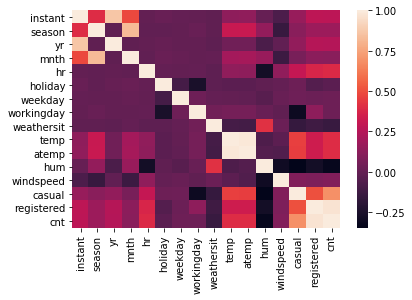

In [75]:
ax = sns.heatmap(hour_raw.corr())

In [105]:
hour_raw = pd.read_csv('data/hour.csv')
season_dummies = pd.get_dummies(data=hour_raw.season, prefix='season')
hour_raw = pd.concat([hour_raw, season_dummies, weathersit_dummies], axis=1)
hour_raw.drop(columns=['season_1', 'weathersit_4'], inplace = True)

hour_raw

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,windspeed,casual,registered,cnt,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,0.0000,3,13,16,0,0,0,1,0,0
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,0.0000,8,32,40,0,0,0,1,0,0
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,0.0000,5,27,32,0,0,0,1,0,0
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,0.0000,3,10,13,0,0,0,1,0,0
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,0.0000,0,1,1,0,0,0,1,0,0
5,6,2011-01-01,1,0,1,5,0,6,0,2,...,0.0896,0,1,1,0,0,0,0,1,0
6,7,2011-01-01,1,0,1,6,0,6,0,1,...,0.0000,2,0,2,0,0,0,1,0,0
7,8,2011-01-01,1,0,1,7,0,6,0,1,...,0.0000,1,2,3,0,0,0,1,0,0
8,9,2011-01-01,1,0,1,8,0,6,0,1,...,0.0000,1,7,8,0,0,0,1,0,0
9,10,2011-01-01,1,0,1,9,0,6,0,1,...,0.0000,8,6,14,0,0,0,1,0,0


In [79]:
hour_raw.head(1)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,spring,summer,fall
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,0,0,0


Predictors -> season, hr, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, cnt, spring, summer, fall

# Targets appear exponentially distributed - trying log transform to coax to normal

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002171EC06FD0>,
      dtype=object)

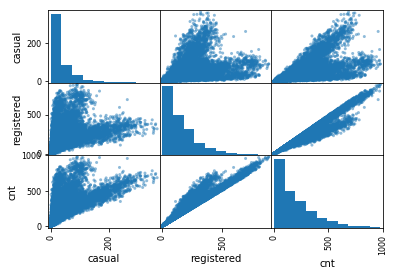

In [86]:
pd.plotting.scatter_matrix(hour_raw.iloc[:,[14,15,16]])

In [ ]:
r